In [0]:
!pip install bayesian-optimization==0.6

  Stored in directory: /root/.cache/pip/wheels/f5/ef/5c/9ff1d2d86ad1117bf4cd3f989356ae46fa907014ece63b09dd
Successfully built bayesian-optimization


I use `bayesian-optimization==0.6`, my backend pretty much stick with this version, so migrating will break the code.

In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()

In [0]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split('.')[0]
        elif isinstance(val, type):
            name = val.__module__.split('.')[0]
        poorly_named_packages = {'PIL': 'Pillow', 'sklearn': 'scikit-learn'}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name


imports = list(set(get_imports()))
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != 'pip':
        requirements.append((m.project_name, m.version))

for r in requirements:
    print( '{}=={}'.format(*r) )

seaborn==0.9.0
pandas==0.24.2
numpy==1.16.4
matplotlib==3.0.3
google==2.0.2


In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

TSLA Time Period: **Mar 23, 2018 - Mar 23, 2019**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls '/content/gdrive/My Drive/Colab Notebooks/prediction_pack'

agent	       free-agent  output	 realtime-agent  stock-forecasting-js
dataset        LICENSE	   output-agent  simulation
deep-learning  misc	   README.md	 stacking


In [0]:
project_folder = '/content/gdrive/My Drive/deep_learning/_data/forex/daily_csv/'
fname = 'EUR_USD Historical Data.csv'
df = pd.read_csv(project_folder+fname)
df.head()

,Date,Price,Open,High,Low,Change %
0,"Feb 28, 2019",1.1413,1.1379,1.1421,1.1368,0.29%
1,"Feb 27, 2019",1.1379,1.1389,1.1404,1.1362,-0.07%
2,"Feb 26, 2019",1.1387,1.1366,1.1404,1.1343,0.25%
3,"Feb 25, 2019",1.1359,1.1338,1.1369,1.1323,0.14%
4,"Feb 22, 2019",1.1343,1.1337,1.1360,1.1315,0.06%


In [0]:
close = np.array(df.Price.values.tolist()).astype(np.float64) * 100
train_count = int(len(close) * (25/100))
close = close[:train_count]
close = np.flip(close).tolist()

window_size = 30
skip = 5
l = len(close) - 1

In [0]:
len(close)

1249

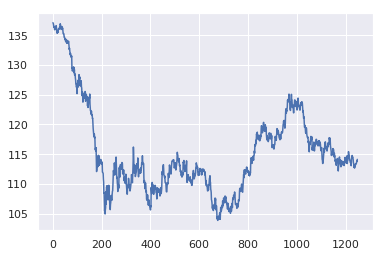

In [0]:
plt.plot(close)

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(100, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),
        'skip': (1, 15),
        'population_size': (1, 50),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 33, 'skip': 13, 'population_size': 15, 'sigma': 0.669486513313823, 'learning_rate': 0.09473020181514512, 'size_network': 332}
time taken to train: 7.2787697315216064 seconds
stop after 100 iteration with investment 1.642600
    1 | 00m07s |    1.64260 |          0.0947 |           14.9685 |    0.6695 |       331.7930 |   12.8640 |       33.0479 | 

Search parameters {'window_size': 44, 'skip': 2, 'population_size': 20, 'sigma': 0.1787135249514537, 'learning_rate': 0.48777571694029387, 'size_network': 847}
time taken to train: 85.3565616607666 seconds
stop after 100 iteration with investment 13.393300
    2 | 01m25s |   13.39330 |          0.4878 |           20.0720 |    0.1787 |       846.8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
    4 | 00m00s |    0.00000 |          0.4600 |           36.3689 |    0.0317 |       283.7663 |   14.8293 |       11.0590 | 

Search parameters {'window_size': 50, 'skip': 14, 'population_size': 33, 'sigma': 0.31621611503053254, 'learning_rate': 0.1714356487380873, 'size_network': 738}
time taken to train: 30.01151156425476 seconds
stop after 100 iteration with investment 8.357500
    5 | 00m30s |    8.35750 |          0.1714 |           33.1286 |    0.3162 |       738.1393 |   14.2209 |       49.6786 | 

Search parameters {'window_size': 37, 'skip': 15, 'population_size': 47, 'sigma': 0.91002846018886, 'learning_rate': 0.4191475363086222, 'size_network': 32}
time taken to train: 9.087537050247192 seconds
stop after 100 iteration with investment 3.404600
    6 | 00m09s |    3.40460 |          0.4191 |           47.1133 |    0.9100 |        32.3183 |   14.9878 |       37.3853 | 

Search parameters {'window_size': 17, 'skip': 12, 'popula

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   76 | 00m31s |    0.00000 |          0.2446 |           32.8212 |    0.0929 |       737.7398 |   12.4895 |       49.5851 | 

Search parameters {'window_size': 34, 'skip': 1, 'population_size': 10, 'sigma': 0.24253816319723287, 'learning_rate': 0.19709971921042135, 'size_network': 108}
time taken to train: 27.945398807525635 seconds
stop after 100 iteration with investment 11.211800
   77 | 00m30s |   11.21180 |          0.1971 |           10.1825 |    0.2425 |       107.8032 |    1.1318 |       34.4525 | 

Search parameters {'window_size': 43, 'skip': 6, 'population_size': 32, 'sigma': 0.6461893483517341, 'learning_rate': 0.08564258076819833, 'size_network': 529}
time taken to train: 43.57392120361328 seconds
stop after 100 iteration with investment 3.938100
   78 | 00m45s |    3.93810 |          0.0856 |           32.1631 |    0.6462 |       528.7108 |    5.7108 |       42.6829 | 

Search parameters {'window_size': 45, 'skip': 4, 'po

In [0]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 21.091500
Best AGENT parameters:  {'window_size': 49.750658632913265, 'skip': 1.9806698209384428, 'population_size': 24.93391976734068, 'sigma': 0.2512612005385464, 'learning_rate': 0.22316621373844, 'size_network': 541.3247604600656}


#### My selected parameters

In [0]:
best_agent(
    window_size = 30, 
    skip = 1, 
    population_size = 15, 
    sigma = 0.1, 
    learning_rate = 0.03, 
    size_network = 500
)

time taken to train: 89.45340394973755 seconds


16.322500000000108

#### bayesian parameters

In [0]:
best_agent(
    window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
    skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
    population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
    sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
    learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
    size_network = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network']))
)

time taken to train: 100.39810609817505 seconds


21.191200000000027

#### My selected parameters

iter 100. reward: 15.717500
iter 200. reward: 17.755600
iter 300. reward: 17.998700
iter 400. reward: 21.476800
iter 500. reward: 21.295000
time taken to train: 446.6532485485077 seconds
day 10: buy 5 units at price 679.850000, total balance 9320.150000
day 15: buy 5 units at price 679.700000, total balance 8640.450000
day 17, sell 5 units at price 676.650000, investment -0.470692 %, total balance 9317.100000,
day 18: buy 5 units at price 677.650000, total balance 8639.450000
day 24: buy 1 units at price 135.990000, total balance 8503.460000
day 25, sell 5 units at price 680.250000, investment 0.080918 %, total balance 9183.710000,
day 26, sell 5 units at price 680.250000, investment 0.383679 %, total balance 9863.960000,
day 27: buy 5 units at price 681.500000, total balance 9182.460000
day 29, sell 5 units at price 682.450000, investment 401.838370 %, total balance 9864.910000,
day 34, sell 1 units at price 135.960000, investment -80.049890 %, total balance 10000.870000,
day 38: buy 

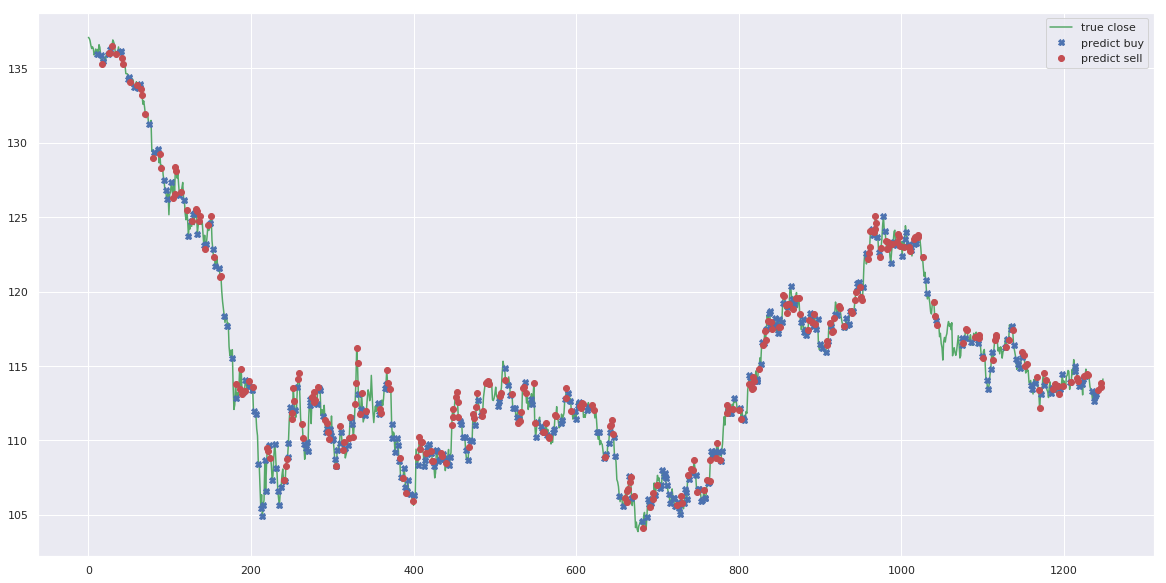

In [0]:
model = Model(input_size = 30, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              model = model, 
              money = 10000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = 1, 
              window_size = 30)
agent.fit(500, 100)
agent.buy()

#### bayesian parameters

iter 100. reward: 64.236000
iter 200. reward: 80.489000
iter 300. reward: 93.612000
iter 400. reward: 96.383000
iter 500. reward: 100.156000
time taken to train: 503.0960910320282 seconds
day 4: buy 5 units at price 681.700000, total balance 318.300000
day 14: buy 5 units at price 682.150000, total balance -363.850000
day 20, sell 5 units at price 678.750000, investment -0.432742 %, total balance 314.900000,
day 28: buy 5 units at price 680.550000, total balance -365.650000
day 30, sell 5 units at price 684.600000, investment 0.359159 %, total balance 318.950000,
day 32, sell 5 units at price 683.000000, investment 0.360003 %, total balance 1001.950000,
day 34: buy 5 units at price 679.800000, total balance 322.150000
day 38, sell 5 units at price 680.500000, investment 0.102971 %, total balance 1002.650000,
day 42: buy 1 units at price 135.250000, total balance 867.400000
day 46, sell 1 units at price 134.660000, investment -0.436229 %, total balance 1002.060000,
day 50: buy 5 units a

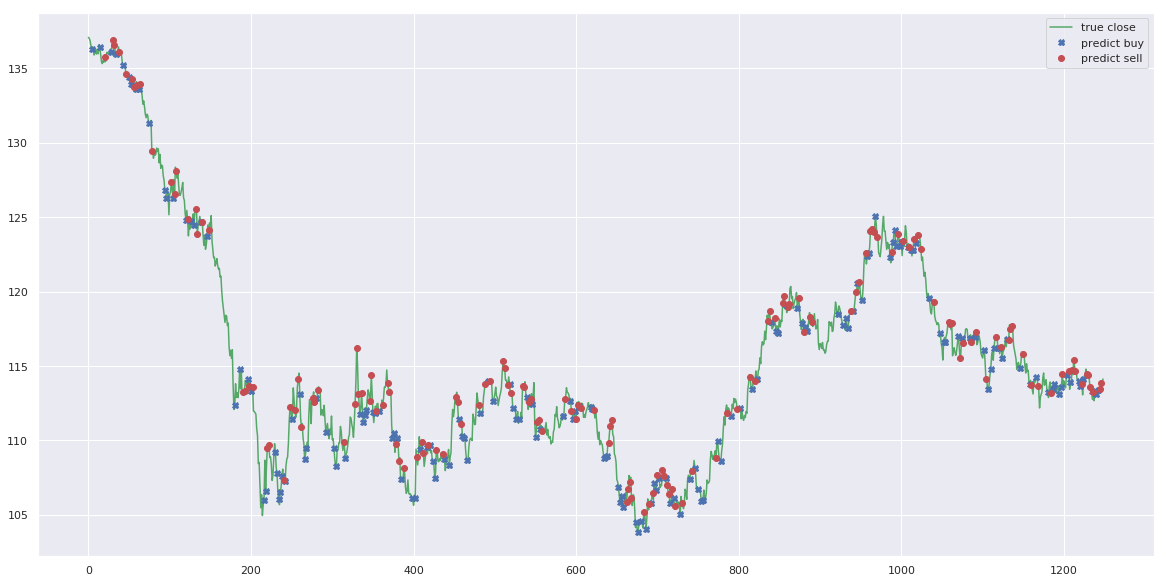

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])), 
              layer_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['population_size'])), 
              sigma = NN_BAYESIAN.res['max']['max_params']['sigma'], 
              learning_rate = NN_BAYESIAN.res['max']['max_params']['learning_rate'], 
              model = model, 
              money = 1000, 
              max_buy = 5, 
              max_sell = 5, 
              skip = int(np.around(NN_BAYESIAN.res['max']['max_params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.res['max']['max_params']['window_size'])))
agent.fit(500, 100)
agent.buy()

day 4: buy 5 units at price 681.700000, total balance 318.300000
day 14: buy 5 units at price 682.150000, total balance -363.850000
day 20, sell 5 units at price 678.750000, investment -0.432742 %, total balance 314.900000,
day 28: buy 5 units at price 680.550000, total balance -365.650000
day 30, sell 5 units at price 684.600000, investment 0.359159 %, total balance 318.950000,
day 32, sell 5 units at price 683.000000, investment 0.360003 %, total balance 1001.950000,
day 34: buy 5 units at price 679.800000, total balance 322.150000
day 38, sell 5 units at price 680.500000, investment 0.102971 %, total balance 1002.650000,
day 42: buy 1 units at price 135.250000, total balance 867.400000
day 46, sell 1 units at price 134.660000, investment -0.436229 %, total balance 1002.060000,
day 50: buy 5 units at price 672.050000, total balance 330.010000
day 52: buy 5 units at price 669.850000, total balance -339.840000
day 54, sell 5 units at price 671.500000, investment -0.081839 %, total bala

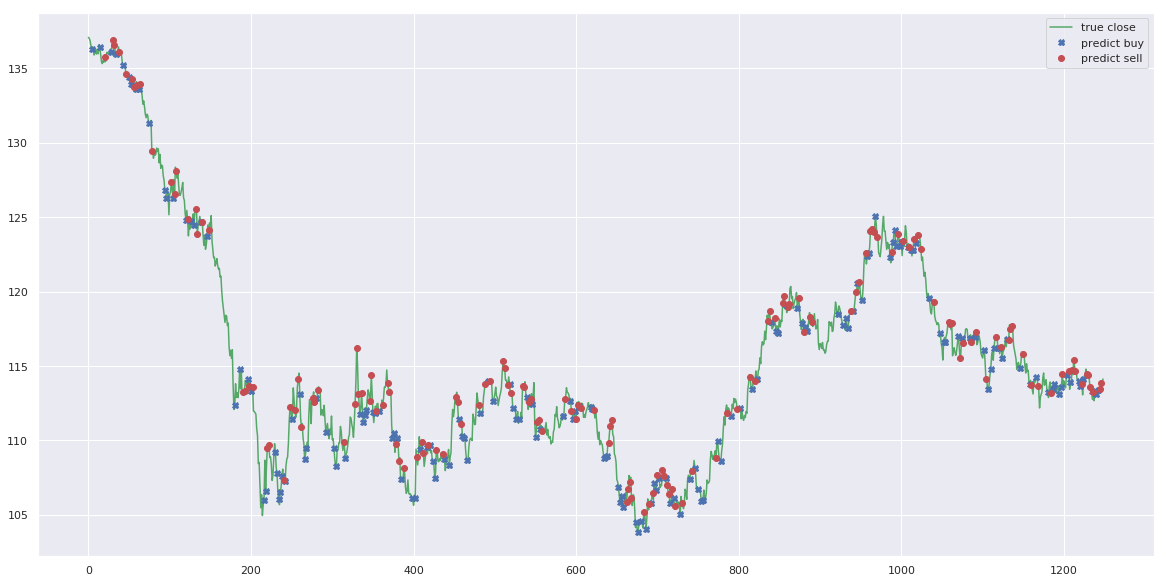

In [0]:
agent.buy()

In [0]:

model.predict()

TypeError: ignored

In [0]:
len(model.weights)

4

In [0]:
model.weights[0].shape

(50, 541)

In [0]:
agent.window_size

50

In [0]:
project_folder = '/content/gdrive/My Drive/deep_learning/_data/forex/daily_csv/'
fname = 'last50_eurusd.csv'
df = pd.read_csv(project_folder+fname)
df.head()

,Date,Price,Open,High,Low,Change %
0,"Jul 12, 2019",1.1271,1.1250,1.1276,1.1238,0.19%
1,"Jul 11, 2019",1.1250,1.1258,1.1286,1.1245,-0.01%
2,"Jul 10, 2019",1.1251,1.1208,1.1265,1.1202,0.38%
3,"Jul 09, 2019",1.1208,1.1215,1.1221,1.1194,-0.06%
4,"Jul 08, 2019",1.1215,1.1221,1.1235,1.1205,-0.10%


In [0]:
last50 = df.Price.values[:50] * 100

In [0]:
predict_decision, predict_buy = model.predict(last50)

In [0]:
predict_decision

array([[-421157.46432664,  330353.60230215, -402398.91972337]])

In [0]:
predict_buy

array([[-221498.18243169]])

In [0]:
agent.act(last50)

(1, -221498)

In [0]:
  initial_money = 500
  starting_money = initial_money
  states_sell = []
  states_buy = []
  inventory = []
  quantity = 0

  action, buy = agent.act(last50)
  if action == 1 and initial_money >= last50[-1]:
    print('buy')
    if buy < 0:
      buy = 1
    if buy > agent.max_buy:
      buy_units = agent.max_buy
    else:
      buy_units = buy
      total_buy = buy_units * last50[-1]
      initial_money -= total_buy
      print('day %s: buy %d units at price %f, total balance %f'
            % ('today', buy_units, total_buy, initial_money))
  elif action == 2 and len(inventory) > 0: 
      print('sell')

buy
day today: buy 1 units at price 112.000000, total balance 388.000000
